In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import json
import os, glob
import scipy, scipy.io


import matplotlib
from matplotlib import *
from matplotlib import pyplot as plt
import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable

from itertools import compress

import sys
sys.path.append('/usr/local/lib/python2.7/site-packages')

# pretty charting
import seaborn as sns
sns.set_palette('muted')
sns.set_style('darkgrid')

%matplotlib inline

In [8]:
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], scipy.io.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, scipy.io.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        elif isinstance(elem,np.ndarray):
            dict[strg] = _tolist(elem)
        else:
            dict[strg] = elem
    return dict

def _tolist(ndarray):
    '''
    A recursive function which constructs lists from cellarrays 
    (which are loaded as numpy ndarrays), recursing into the elements
    if they contain matobjects.
    '''
    elem_list = []            
    for sub_elem in ndarray:
        if isinstance(sub_elem, scipy.io.matlab.mio5_params.mat_struct):
            elem_list.append(_todict(sub_elem))
        elif isinstance(sub_elem,np.ndarray):
            elem_list.append(_tolist(sub_elem))
        else:
            elem_list.append(sub_elem)
    return elem_list

def convertMatToJSON(matData, fileName):
    for key in matData.keys():
        if (type(matData[key])) is np.ndarray:
            serializedData = pickle.dumps(matData[key], protocol=0) # protocol 0 is printable ASCII
            jsonData[key] = serializedData
        else:
            jsonData[key] = matData[key]

    with contextlib.closing(bz2.BZ2File(fileName, 'wb')) as f:
        json.dump(jsonData, f)
        
def degreeofagree(ezset, cezset, allset, metric='default'):
    if metric == 'default':
        notcez = list(set(allset) - set(cezset))
        cez_int_eez = list(set(cezset) & set(ezset))
        notcez_int_eez = list(set(notcez) & set(ezset))

        term1 = len(cez_int_eez) / len(cezset)
        term2 = len(notcez_int_eez) / len(notcez)

        doa = term1 - term2
    elif metric == 'jaccard':
        cez_int_eez = list(set(cezset) &  set(ezset))
        cez_and_eez = list(set(cezset).union(ezset))
        
        doa = len(cez_int_eez) / len(cez_and_eez)
        
    return doa

/Users/adam2392/.virtualenvs/tvb/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


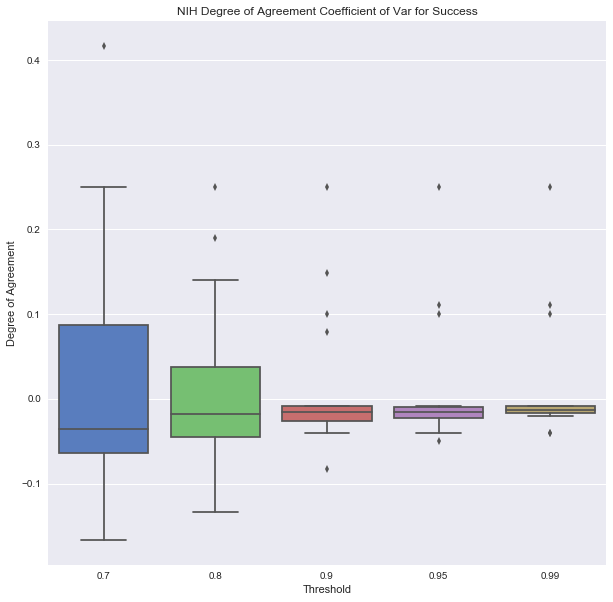

In [9]:
dataDir = '/Users/adam2392/Documents/adamli/fragility_dataanalysis/' + \
    'figures/fragilityStats/notchfilter/perturbationC_win250_step125_radius1.5/ictal_hardcoded/success'
filelist = glob.glob(os.path.join(dataDir, '*.mat'))

# thresholds to set on the preictal, ictal times of coefficient of variation / other frag stats
thresholds = [0.7, 0.8, 0.9, 0.95, 0.99]

nih_doas = np.zeros((len(filelist), len(thresholds)))
nih_ezsets = np.array(())
nih_pats = []
# Load each dataset's fragility statistics results
for idx, fil in enumerate(filelist):
    datastruct = loadmat(os.path.join(dataDir, fil))
    features = datastruct['features_struct']

    colnames = features.keys()
    for col in colnames:
        try:
            features[col] = features[col]/max(features[col])
        except:
            1+1
#             print col, " does not work"
    # extract all the fragility stats
    patient = features['patient']
    min_frag = features['min_frag']
    max_frag = features['max_frag']
    ez_asymmetry = features['ez_asymmetry']
    resected_asymmetry = features['resected_asymmetry']
    network_fragility = features['network_fragility']
    cfvar_time = features['cfvar_time']
    cfvar_chan = features['cfvar_chan']
    channels = features['included_labels']
    cezset = features['ezone_labels']

    # only if the dataset was ictal
    precfvar_chan = features['precfvar_chan']
    postcfvar_chan = features['postcfvar_chan']
    post20cfvar_chan = features['post20cfvar_chan']
    post30cfvar_chan = features['post30cfvar_chan']
    post40cfvar_chan = features['post40cfvar_chan']
    post50cfvar_chan = features['post50cfvar_chan']

    # extract the clinical meta data for this patient

    # go through each threshold and determine set of electrodes within EZ set 
    pat_doas = np.zeros((1, len(thresholds)))
    pat_ezsets = []
    for jdx, threshold in enumerate(thresholds):
        # get the indices that pass threshold for coefficient of variation
        cfvar_threshed_ind = postcfvar_chan >= threshold

        # get the actual cv and the electrode name
        cfvar_threshed = list(compress(postcfvar_chan, cfvar_threshed_ind))
        ezset = list(compress(channels, cfvar_threshed_ind))

        # compute doa
        doa_threshold = degreeofagree(ezset, cezset, channels)

        # store the channel for this threshold
        pat_doas[0, jdx] = doa_threshold
        pat_ezsets.append(np.array(ezset))

    # convert the patient ez sets into an np array
    pat_ezsets = np.array(pat_ezsets).reshape(len(thresholds), 1)

    # store the pats in a list
    nih_pats.append(patient)

    # store the pat ez sets 
    if nih_ezsets.size == 0:
        nih_ezsets = pat_ezsets
    else:
        nih_ezsets = np.append(nih_ezsets, pat_ezsets, axis=1)

    # store the pat doa into the center doa array
    nih_doas[idx, :] = pat_doas

# print nih_pats
# print nih_ezsets
# print nih_doas
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.title('NIH Degree of Agreement Coefficient of Var for Success')
plt.xlabel('Threshold')
plt.ylabel('Degree of Agreement')
g = sns.boxplot(pd.DataFrame(nih_doas))
xticklabels = g.get_xticklabels()
g.set_xticklabels([str(threshold) for threshold in thresholds])

/Users/adam2392/.virtualenvs/tvb/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


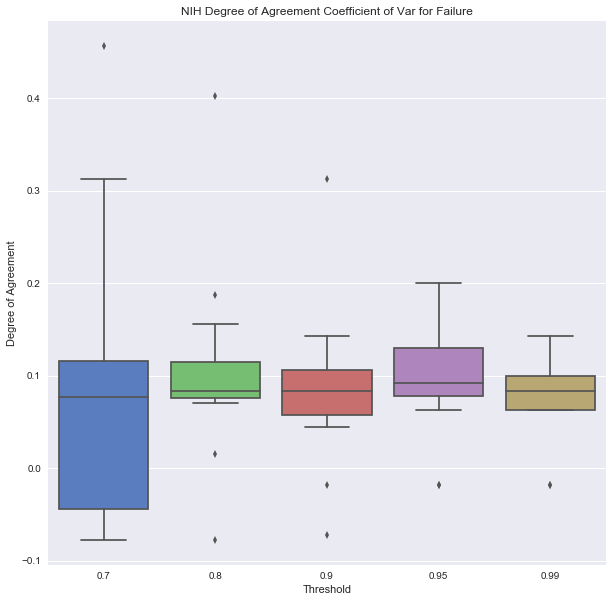

In [11]:
dataDir = '/Users/adam2392/Documents/adamli/fragility_dataanalysis/' + \
    'figures/fragilityStats/notchfilter/perturbationC_win250_step125_radius1.5/ictal_hardcoded/failure'
filelist = glob.glob(os.path.join(dataDir, '*.mat'))

# thresholds to set on the preictal, ictal times of coefficient of variation / other frag stats
thresholds = [0.7, 0.8, 0.9, 0.95, 0.99]

nih_doas = np.zeros((len(filelist), len(thresholds)))
nih_ezsets = np.array(())
nih_pats = []
# Load each dataset's fragility statistics results
for idx, fil in enumerate(filelist):
    datastruct = loadmat(os.path.join(dataDir, fil))
    features = datastruct['features_struct']

    colnames = features.keys()
    for col in colnames:
        try:
            features[col] = features[col]/max(features[col])
        except:
            1+1
#             print col, " does not work"
    # extract all the fragility stats
    patient = features['patient']
    min_frag = features['min_frag']
    max_frag = features['max_frag']
    ez_asymmetry = features['ez_asymmetry']
    resected_asymmetry = features['resected_asymmetry']
    network_fragility = features['network_fragility']
    cfvar_time = features['cfvar_time']
    cfvar_chan = features['cfvar_chan']
    channels = features['included_labels']
    cezset = features['ezone_labels']

    # only if the dataset was ictal
    precfvar_chan = features['precfvar_chan']
    postcfvar_chan = features['postcfvar_chan']
    post20cfvar_chan = features['post20cfvar_chan']
    post30cfvar_chan = features['post30cfvar_chan']
    post40cfvar_chan = features['post40cfvar_chan']
    post50cfvar_chan = features['post50cfvar_chan']

    # extract the clinical meta data for this patient

    # go through each threshold and determine set of electrodes within EZ set 
    pat_doas = np.zeros((1, len(thresholds)))
    pat_ezsets = []
    for jdx, threshold in enumerate(thresholds):
        # get the indices that pass threshold for coefficient of variation
        cfvar_threshed_ind = postcfvar_chan >= threshold

        # get the actual cv and the electrode name
        cfvar_threshed = list(compress(postcfvar_chan, cfvar_threshed_ind))
        ezset = list(compress(channels, cfvar_threshed_ind))

        # compute doa
        doa_threshold = degreeofagree(ezset, cezset, channels)

        # store the channel for this threshold
        pat_doas[0, jdx] = doa_threshold
        pat_ezsets.append(np.array(ezset))

    # convert the patient ez sets into an np array
    pat_ezsets = np.array(pat_ezsets).reshape(len(thresholds), 1)

    # store the pats in a list
    nih_pats.append(patient)

    # store the pat ez sets 
    if nih_ezsets.size == 0:
        nih_ezsets = pat_ezsets
    else:
        nih_ezsets = np.append(nih_ezsets, pat_ezsets, axis=1)

    # store the pat doa into the center doa array
    nih_doas[idx, :] = pat_doas

# print nih_pats
# print nih_ezsets
# print nih_doas
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.title('NIH Degree of Agreement Coefficient of Var for Failure')
plt.xlabel('Threshold')
plt.ylabel('Degree of Agreement')
g = sns.boxplot(pd.DataFrame(nih_doas))
xticklabels = g.get_xticklabels()
g.set_xticklabels([str(threshold) for threshold in thresholds])